In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (2*(Euv))
        self.beta = (1-eta)*self.beta + eta * (2*Ev)
        
        self.eta = eta * 0.99
        
        
class ND(nn.Module):
    def __init__(self, layersize, eta=1):
        super(ND, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (2*(Euv))
        self.beta = (1-eta)*self.beta + eta * (2*Ev)


class Net(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(Net, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o
    
class CNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

In [3]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = Net(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training with decay. Run %d" % (1))
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = Net(LAYERSIZE, ND, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training without decay. Run %d" % (1))
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = Net(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training with decay. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = Net(LAYERSIZE, ND, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training without decay. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="With decay")
    # plt.plot(bn_losses[0], bn_losses[1], label="BN")
    plt.plot(standard_losses[0], standard_losses[1], label="Without decay")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training with decay. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CNet(LAYERSIZE, ND, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training without decay. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training with decay. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CNet(LAYERSIZE, ND, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training without decay. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for shallow networks")
    plt.plot(ip_losses[0], ip_losses[1], label="With decay")
    # plt.plot(bn_losses[0], bn_losses[1], label="BN")
    plt.plot(standard_losses[0], standard_losses[1], label="Without decay")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Test

In [4]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


Training with decay. Run 1
[1] loss: 0.312
[2] loss: 0.148
[3] loss: 0.115
[4] loss: 0.100
[5] loss: 0.083
[6] loss: 0.075
[7] loss: 0.069
[8] loss: 0.066
[9] loss: 0.055
[10] loss: 0.056
[11] loss: 0.053
[12] loss: 0.046
[13] loss: 0.050
[14] loss: 0.044
[15] loss: 0.038
[16] loss: 0.042
[17] loss: 0.044
[18] loss: 0.033
[19] loss: 0.035
[20] loss: 0.039
Finished training!

Training without decay. Run 1
[1] loss: 0.305
[2] loss: 0.141
[3] loss: 0.108
[4] loss: 0.090
[5] loss: 0.074
[6] loss: 0.068
[7] loss: 0.059
[8] loss: 0.054
[9] loss: 0.048
[10] loss: 0.045
[11] loss: 0.043
[12] loss: 0.042
[13] loss: 0.041
[14] loss: 0.031
[15] loss: 0.035
[16] loss: 0.033
[17] loss: 0.031
[18] loss: 0.028
[19] loss: 0.032
[20] loss: 0.027
Finished training!

Training with decay. Run 2
[1] loss: 0.317
[2] loss: 0.149
[3] loss: 0.110
[4] loss: 0.096
[5] loss: 0.086
[6] loss: 0.080
[7] loss: 0.064
[8] loss: 0.062
[9] loss: 0.058
[10] loss: 0.053
[11] loss: 0.047
[12] loss: 0.049
[13] loss: 0.044
[1

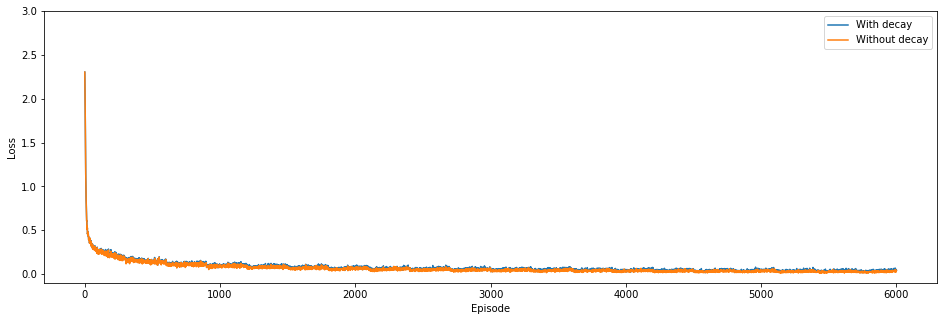

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 20

test_runs = 10

int_lr = 0.25
syn_lr = 0.03

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Test

In [6]:
batchSize = 200

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 50

test_runs = 10

int_lr = 0.25
syn_lr = 0.005

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training with decay. Run 1
[1] loss: 1.790
[2] loss: 1.598
[3] loss: 1.481
[4] loss: 1.392
[5] loss: 1.323
[6] loss: 1.263
[7] loss: 1.209
[8] loss: 1.158
[9] loss: 1.106
[10] loss: 1.054
[11] loss: 1.010
[12] loss: 0.971
[13] loss: 0.923
[14] loss: 0.883
[15] loss: 0.849
[16] loss: 0.810
[17] loss: 0.775
[18] loss: 0.742
[19] loss: 0.710
[20] loss: 0.683
[21] loss: 0.653
[22] loss: 0.634
[23] loss: 0.600
[24] loss: 0.574
[25] loss: 0.552
[26] loss: 0.531
[27] loss: 0.512
[28] loss: 0.487
[29] loss: 0.470
[30] loss: 0.448
[31] loss: 0.436
[32] loss: 0.424
[33] loss: 0.416
[34] loss: 0.390
[35] loss: 0.377
[36] loss: 0.360
[37] loss: 0.366
[38] loss: 0.346
[39] loss: 0.326
[40] loss: 0.323
[41] loss: 0.311
[42] loss: 0.293
[43] loss: 0.297
[44] loss: 0.287
[45] loss: 0.286
[46] loss: 0.269
[47] loss: 0.243
[48] loss: 0.274
[49] loss: 0.263
[50] loss: 0.252
Finished training!

Training without decay. Run 1
[1] loss: 1.787
[2] loss: 1.591
[3] loss: 1.477
[4] loss: 1.393
[5] loss: 1.330
[6

Process Process-1205:
Process Process-1206:
Traceback (most recent call last):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indi

Traceback (most recent call last):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-27b4e5be891e>", line 11, in <module>
    run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)
  File "<ipython-input-3-994fd0592e7d>", line 133, in run_cifar_experiment
    ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)
  File "<ipython-input-3-994fd0592e7d>", line 14, in train_deep_model
    for i, data in enumerate(trainloader):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/queues.py", line 343, in get
    r

KeyboardInterrupt: 